<a href="https://colab.research.google.com/github/pietroventurini/machine-learning-notes/blob/main/2%20-%20Model%20evaluation%20and%20validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation and Validation

### Contents

1. [**Introduction**](#Introduction)
2. [**Evaluation metrics**](#Evaluation-metrics)  
    1. Metrics for regression  
        1. Mean squared error  
        2. Root mean squared error  
        3. Coefficient of determination  
        4. Mean absolute error  
        5. Mean squared percentage error  
        6. Mean absolute percentage error  
        7. Root mean square logarithmic error  
    2. Metrics for classification    
        1. Confusion Matrix  
        2. Accuracy  
        3. Precision  
        4. Recall  
        5. Specificity & False alarm rate  
        6. $F_1$ score  
        7. $F_\beta$ score  
        8. ROC curve  
        9. AUC  
        10. Logarithmic loss  
        11. Cohen's Kappa  
3. [**Model selection: detecting and fixing errors**](#Model-selection)  
    1. Cross validation  
    2. Bootstrap method  
    3. Considerations to make when splitting the dataset into train/validation  
    4. Learning curves  
    5. Grid search  
    6. Different scores between validation and test set  
4. [**Formalization of some concepts from _"Machine Learning"_ by Thomas Mitchell**](#Mitchell)  
    1. Confidence intervals for discrete-valued hypothesis
    2. Error estimation
    3. Comparing hypotheses
    4. Comparing learning algorithms

<a name='Introduction'></a>
## Introduction

The first question we need to ask ourselves is "***How well our model is doing?***". This question can be answered through the use of metrics. That will lead us to a second question: "***How do we improve the model based on these metrics?***".

This chapter presents some statistical methods focusing on these questions:
1. Given the observed accuracy of a hypothesis $h$ (a **model**) over a limited sample of data, how well does it estimates its accuracy over additional data examples?
2. Given that an hypothesis $h$ outperforms another $h'$ over some sample data, how probable is that $h$ is more accurate in general?
3. When data is limited, what is the best way to use it to both learn a hypothesis $h$ and estimate its accuracy?

These questions arise from the fact that a limited dataset might misrepresent the general underlying distribution of data. Statistical methods (together with assumptions about the underlying distribution) allow to bound the difference between observed accuracy and the true accuracy over the entire distribution.

There are many **reasons** why we should evaluate a model. In many applications it is important to understand as precisely as possible the accuracy of the learned hypothesis (e.g. a model to predict the effectiveness of different medical treatments must be as accurate as possible). Furthermore, in many learning methods, hypothesis evaluation is an integral step of the method itself, for example, when post-pruning a decision tree, the impact of a possible pruning step has to be evaluated.

When we train the model over a limited dataset, two main factors arise **in the estimate of the hypothesis accuracy**:
- **Bias in the estimate** (prediction bias): when the learner considers a very wide hypothesis space, it faces the risk of constructing a model that performs well on the training examples but fails to generalize over new data (because few training data failed to provide meaningful information about the entire underlying distribution). This fact typically happens when the learner considers a very wide hypothesis space. The model accuracy over the training set (i.e. how does it perform over the same data that have been used to train it) is a **biased estimate** of its accuracy over future unseen examples. For this reason we should evaluate the hypothesis on a **test set** chosen independently of the training examples and the hypothesis. Remember: ***NEVER use the test set to train the model***.

$$\text{prediction bias} = \text{average of predictions} - \text{average of true target values in the data set}$$

- **Variance in the estimate** (prediction variance): even if the hypothesis accuracy is measured over an unbiased set of test examples, the measured accuracy can still vary from the true accuracy, depending on the makeup of the test set. The smaller the test set, the greater the expected variance.

More on these two concepts in the section "From the book: 'Machine Learning' by Thomas Mitchell".

## Exercise: evaluate the model performance on a test set
- **Loading data:** Data can be read using the command `read_csv("file_name.csv")` from the [Pandas](https://pandas.pydata.org/) Python library. After loading the dataframe, we can extract columns from it, and putting them into numpy arrays: `X = np.array(data[['x1','x2']])`.

- **Training model:** Training of the model can be done using classifiers provided within the [scikit-learn](https://scikit-learn.org) library.

- **Evaluating the model:** Evaluation of the model can be done by testing the model with new data. `scikit-learn` classifiers have a `score()` method that can be used to evaluate the model. Remember this rule: ***never use testing data for training***.

Accuracy of the predictions = 0.76


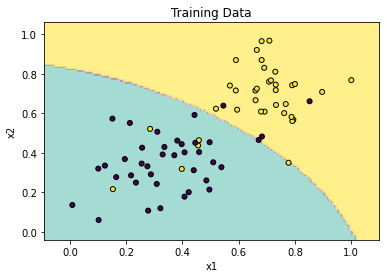

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Read the data
data = pd.read_csv('datasets/model_evaluation/data.csv')

# Split the data into input X and target y
X = np.array(data[['x1', 'x2']])
y = np.array(data['y'])

# Split the data into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Define a classifier
# classifier = LogisticRegression(solver='liblinear')
# classifier = MLPClassifier()
# classifier = DecisionTreeClassifier()
classifier = SVC(kernel='poly', degree=2, gamma='scale')

# Fit the classifier to the data
classifier.fit(X_train, y_train)

# Evaluate the model
print('Accuracy of the predictions = {}'.format(classifier.score(X_test, y_test)))

# Plot data and decision boundaries
x_min, x_max = X_train[:, 0].min() - .1, X_train[:, 0].max() + .1
y_min, y_max = X_train[:, 1].min() - .1, X_train[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),
                     np.arange(y_min, y_max, .01))

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]) # predict output class for every point of the meshgrid
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Set3, alpha=0.8)
plt.scatter(X_train[:,0], X_train[:,1], marker='o', c=y_train, s=25, edgecolor='k')
plt.title('Training Data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<a name='Evaluation-metrics'></a>
# Evaluation metrics

In competitions it is very important to optimize our model with respect to the metrics being used to evaluate the submissions in the competition. Optimizing with respect to different metrics can lead to very different models and results. Note that some metrics can't be optimize efficiently, that is, there is not a simple enough way to find, say, the optimal hyperplane. Therefore, sometimes we have to train our model to optimize something different than competition metric, but in this case we will need to apply various heuristics to improve competition metric score.

When the train and test sets have different target distributions (and that can be checked by computing the difference between the mean target values of the train and test set), we can adjust our predictions in order to taking this fact into account. Doing this is some sort of metric optimization technique. In more severe cases, improved metric on the validation set can possibly not result into improved metric on the test set. In these situations it is a good idea to stop and think of a different way to approach the problem.

In particular, with time series, even if we did the validation just right (split by time, rolling windows), the distribution in the future can be much different from the training set. Sometimes there is just not enough training data, so the model is unable to capture the patterns. 

Even if in competitions the metric to optimize is already chosen for us, it is useful to understand when a metric should be preferred to another.

A metric is what we want to optimize, for instance, the accuracy of a model. Unfortunately, we don't know how to optimize many of the typically used metrics, but instead, we come up with a proxy loss function that is easier to optimize for a given model. For example, logarithmic loss is frequently used as an optimization loss, while the accuracy score is used to eventually evaluate a solution. In many cases the loss function is the same as target metric (e.g. MSE, logloss), but when that's not the case, we first optimize the loss metric and then we use heuristics to reduce the discrepancy and adjust the model to better fit target metric.

## Metrics for regression

Now we will introduce some of the most common metrics adopted when solving regression problems. [Additional metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) are provided by the scikit learn library.

### Mean Squared Error

When we don't have any particular preference for the solution to our problem, mean squared error (MSE), is the most common metric.

$$MSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$

Note that, if we want to predict the same constant value, independently of the observed variables $x_i$, then our best guess would be the expected value of $y$, that is its **mean** value.

In practice, MSE can be optimized by almost every library: 
- **Tree-based:** XGBoost, LightGBM, sklearn.RandomForestRegressor
- **Linear models:** sklearn.<>Regression, sklearn.SGDRegressor, Vowpal Wabbit
- **Neural networks:** PyTorch, Keras, TensorFlow

### Root Mean Squared Error

RMSE is identical to MSE, except for the square root, that is introduced to make the scale of the errors to be the same as the scale of the target. 

$$RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$$

Since the square root function is non-decreasing, then the minimizer of MSE is the same as the minimizer of RMSE, and viceversa. More generally, if we have two sets of predictions $a$ and $b$, then $MSE(a) > MSE(b) \Leftrightarrow RMSE(a) > RMSE(b)$. That said, if in a competition the metric to optimize is RMSE, then we can optimize using MSE (which is easier to work with) and still pursue the goal.

Note that the partial derivative of the RMSE with respect to the i-*th* prediction is

$$\frac{\partial RMSE}{\partial \hat{y}_i} = \frac{1}{2\sqrt{MSE}} \frac{\partial MSE}{\partial \hat{y}_i}$$

so, it is equal to the gradient of the MSE rescaled by a constant that is independent of the index $i$. That means that travelling along the MSE gradient is equivalent to travelling along the RMSE gradient, but with different learning rate which depends on the MSE score itself (so, it is kind of dynamic). Therefore, even though RMSE and MSE are really similar in terms of models scoring, they can be not immediately interchangeably for gradient based methods.

### Coefficient of determination

It is quite difficult to realize if our model is good or not by just looking at the MSE or RMSE, since they depend on the properties of the dataset and on the target vector. The [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$ tells us how much better our model is with respect to the simplest model that always predicts the average of the target values. In other words, it describes the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

$$ R^2 = 1-\frac{\text{Residual Sum of Squares}}{\text{Total Sum of Squares}} = 1-\frac{\sum_{i=1}^{n}{(y_i-\hat{y}_i)^2}}{\sum_{i=1}^{n}{(y_i-\bar{y})^2}}$$

where:
- $y_i$ is the observed value
- $\hat{y}_i$ is the predicted value
- $\bar{y}$ is the mean observed value

$R^2$ is a measure of how close the data are to the fitted regression line. In the best case, the modeled values exactly match the observed values, which results in $SS_{res} = 0$ and $R^2 = 1$. A baseline model, which always predicts $\overline{y}$, will have $R^2= 0$. Models that have worse predictions than this baseline will have a negative $R^2$. By optimizing for the MSE we optimize also for $R^2$.

### Mean Absolute Error

Mean absolute error (MAE) is defined as follows:

$$MAE = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$$ 

Since it penalizes large errors not as much as MSE does, it is not that sensitive to outliers as mean square error. MAE is usually used in finance (where a 10€ error is twice as worse as a 5€ error, while instead the MSE metric thinks that a 10€ error is four times worse than a 5€ error). If we were to predict a constant value, then the best constant would be the target **median**.


In practice, MAE can be optimized by many library: 
- **Tree-based:** LightGBM, sklearn.RandomForestRegressor
- **Linear models:** Vowpal Wabbit
- **Neural networks:** PyTorch, Keras, TensorFlow

### Mean Squared Percentange Error

Consider the problem of predicting how many laptops two shops will sell. In the training set, for a particular date, we see that the first shop sold 10 items, while the second one sold 1000. Assume now that our models predicts 9 sold items for the first shop, and 999 for the second one:

|            | sold | predicted | MSE |
|:----------:|:----:|:---------:|:---:|
| **Shop 1** |  10  |     9     |  1  |
| **Shop 2** | 1000 |    999    |  1  |

As we can imagine, an off-one error on the first shop is more critical than an off-one error on the second, anyway, MSE (and RMSE) are the same for both shops. This happens because MSE and RMSE works with absolute errors instead of relative ones. The relative error preference can be expressed with **mean squared percentange error (MSPE)** or with **mean absolute percentange error (MAPE)**.

$$MSPE= \frac{100\%}{N} \sum_{i=1}^{N}\left(\frac{y_i - \hat{y}_i}{y_i}\right)^2$$

For a fixed amount of absolute error, as the target value increases, we pay less. MSPE can be thought as of a weighted version of MSE where, for each object, the absolute error is divided by the target value, giving the relative error. Note that the weights do not sum up to 1.

The best constant prediction for the MSPE is the **weighted mean** of the target values.


In practice, MSPE can be optimized either by implementing a custom loss function that will be provided to XGBoost or to the main neural networks frameworks, or by optimizing a different metric and do early stopping. For instance, we can weight each sample and use MSE. In that case, the weights will be defined as:

$$w_i= \frac{1/y_i^2}{\sum_{i=1}^{N}1/y_i^2}$$

If the library we are using does not support sample weights, we can easily resample our train set with `df.sample(weights=sample_weights` and use any model that optimizes MSE.

### Mean Absolute Percentage Error

The same considerations we did for the MSPE hold also for the mean absolute percentage error, which is defined as:

$$MAPE= \frac{100\%}{N} \sum_{i=1}^{N}\left\vert\frac{y_i - \hat{y}_i}{y_i}\right\vert$$

The best constant prediction for the MAPE is the **weighted mean** of the target values.

In practice, the same considerations we did for MSPE hold also for MAPE, with the weights being computed as:

$$w_i = \frac{1/y_i}{\sum_{i=1}^{N} 1/y_i}$$

### Root mean square logarithmic error

(R)MSLE is just (R)MSE calculated in logarithmic scale:

$$\begin{align} RMSLE &= \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left(\log(y_i + 1) - \log(\hat{y}_i+1)\right)^2} \\
&= RMSE\left(\log(y_i + 1), \log(\hat{y}_i+1)\right)\end{align}$$

This metric is used in the same situations as MSPE and MAPE. The best constant score for RMSLE is the **exponential of the mean of the log target values**.

In practice, we can optimize this metric in this way:
1. Transform the target variable in the train set:

$$z_i = \log(y_i+1)$$

2. Fit a model with MSE loss
3. Perform predictions $\hat{z}_i$ over the test set using the model, and transform them back:

$$\hat{y}_i = \exp(\hat{z}_i) - 1$$

## Metrics for classification

### Confusion matrix

A tool to evaluate the performances of our classification model is the **confusion matrix**. A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is a matrix in which each row represents the instances in a predicted class while each column represents the instances in an actual class. For a binary classification problem, the correctly classified instances take the name of *true positives/negatives*, while the wrong ones take the name of *false positives/negatives* (a false positive is a negative instance which has been erroneously classified as positive, while a false negative is a positive record which has been classified as negative).

**False positives** are also called **Type I error**, while **False negatives** are also called **Type II errors** (more on that [HERE](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors)).

|                      | Positive | Negative |
|----------------------|----------|----------|
| **Guessed positive** | TP       | FP       |
| **Guessed negative** | FN       | TN       |

Consider the following example of a simple binary classification problem in which we predict the positive class (blue) for the data points above our curve, and the negative class (red) for the points below it:

<img src="https://github.com/pietroventurini/machine-learning-notes/blob/main/images/model-evaluation/confusion-matrix.png?raw=1" alt="simple binary classification example" style="display: block; margin-left: auto; margin-right: auto; width:20em" />

The confusion matrix turns out to be:

|                      | Positive | Negative |
|----------------------|----------|----------|
| **Guessed positive** | 6        | 2        |
| **Guessed negative** | 1        | 5        |

### Accuracy

Accuracy is used to measure how good a model is. Accuracy answers to the question: *among all the instances, how many did we classify correctly?* The answer is the ratio between the number of correct predictions and the total number of instances. In our binary classification example:

$$\frac{\text{correct predictions}}{\text{total predictions}}= \frac{TP + TN}{TP + TN + FP + FN} =\frac{6+5}{14}=78.57\%$$

Accuracy can be easily evaluated in `scikit-learn` using the `accuracy_score()` function.
```python
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
```

More generally, accuracy is defined as:

$$Accuracy = \frac{1}{N}\sum_{i=1}^{N} \mathbb{1}\left[\hat{y}_i = y_i \right]$$

The best constant prediction for the accuracy metric is the **most frequent class**.

**Note:** Accuracy can be a misleading metric for *imbalanced datasets* (sets in which the target variable distribution is far to be uniform). Indeed, consider a binary classification problem in which we want to predict whether a tumor is malignant (positive class) or benign (negative class), over a dataset with 100 instances, respectively classified as follows:

|                       | Malignant (+) | Benign (-) |
|-----------------------|---------------|------------|
| Guessed malignant (+) | 1             | 1          |
| Guessed benign (-)    | 8             | 90         |

The accuracy of our model is:

$$\frac{TP + TN}{TP + TN + FP + FN} = \frac{1+90}{1+90+1+8} = 0.91$$

We correctly predicted 91% of our examples, actually doing a great job in classifying benign tumors (90 benign tumors over 91 have been correctly classified). Anyway, over the 9 malignant tumors, only 1 of them has been correctly classified, a terrible outcome, as 8 out of 9 malignancies went undiagnosed!

Accuracy alone doesn't tell the full story when you're working with a class-imbalanced data set, like this one, where there is a significant disparity between the number of positive and negative labels.

**Example:** In the game of roulette there are 38 slots (in the American version), and the ball can end up on one of these slots. An ML model, by using visual features, correctly predicts the landing slot with an accuracy of 5%. Is this a good model? Yes, it is, because a random guess would be correct 1/38 of the time yelding an accuracy of 2.63% which is lower than the model's accuracy.

**Example:** A virus afflicts 0.01% of the population (1 person every 10'000). An ML model, using symptoms as inputs, predicts if a person has the virus with an accuracy of 99.99%. Is this a good model? Not necessarily, because even a dumb model that always predicts a negative outcome would have that precision, but it would be useless to identify positive cases.

### Precision
Precision is the answer to the question: *out of all the data points predicted to be positive, how many of them were actually positive?*
Precision is given by the ratio between the correctly classified positive instance and the total number of true and false positives.

$$\frac{TP}{TP+FP}=\frac{6}{6+2}=75.00\%$$

In other words, when the model classifies a data point as positive, it is correct 75% of the time. The higher the precision, the more confident we can be that our model output is correct.

**Notes:**
- The tradeoff of optimizing for precision is that we will increase the number of false negatives by excluding possibily relevant results.
- In general, raising the classification threshold (above which we classify as positive) reduces false positives, thus raising precision.
- A model that does not produce any false positive has a precision of 1.

### Recall
Recall (or *Sensitivity*, or *True Positive Rate*) answers to the question: *out of the data points that are labeled positive, how many of them do we correctly predicted as positive?*

$$\frac{TP}{TP+FN}=\frac{6}{6+1}=85.71\%$$

In other words, it correctly classifies 85.71% of all positive data points. The higher the recall, the more confident we can be that all the relevant results are included in the output.

**Notes:**
- The tradeoff of optimizing for recall is that we will increase the number of false positives by including possibly irrelevant results. 
- Raising the classification threshold will cause recall to either stay constant or decrease.
- A model that does not produce any false negative has a recall of 1.

When defining the reward function (the loss function), we’ll be able to “weigh” outcomes differently. Weighing the cost of false positives and false negatives is a critical decision that will shape the effectiveness of our model. Unfortunately, these 2 metrics are often in tension: improving one reduces the other. To evaluate our model's effectiveness, we should examine both precision and recall, preferring one over the other according to the specific problem we're facing. In general, a model that outperforms another model on both precision and recall is likely the better model.

### Specificity & False alarm rate

Two additional metrics are:

- **Specificity** (or True Negative Rate): *out of all the negative data points, how many of them were correctly classified as negative?*

$$\text{Specificity}=\frac{TN}{TN+FP}$$

- **False alarm rate** (or False Positive Rate): *out of all the negative data points, how many of them we mistakenly clasiffied to be positive?*

$$\text{False alarm rate}=\frac{FP}{TN+FP} = 1-\text{Specificity}$$

Take also a look at [Sensitiviy and Specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity).

### F<sub>1</sub> score
Precision and recall can be combined into a single metric called **[$F_1$ score](https://en.wikipedia.org/wiki/F1_score)**, which is the harmonic mean between precision and recall. An $F_1$ score reaches its best value at 1. That value tends to be closer to the smallest one.

$$F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

### F<sub>$\beta$</sub> score
More generally, in order to prefer precision over recall (or viceversa) for our model, we can use the $F_\beta$ score:

$$F_\beta = (1+\beta^2) \frac{\text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}$$

$\beta$ is chosen such that recall is considered $\beta$ times as important as precision:
- if $\beta = 0$ then we get **precision**.
- if $\beta \rightarrow +\infty$ then we get **recall**.
- if $\beta = 1$ then we get the **harmonic mean** of precision and recall (i.e. the $F_1$ score).

### ROC curve

A *Receiver Operating Characteristic* curve, or [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the **true positive rate** (TPR, or Recall, or Sensitivity, on the *y* axis) against the **false positive rate** (FPR, on the *x* axis) at different classification thresholds. If we move the threshold at the very right-hand side, then TPR = 0 and FPR = 0, since we would classify every entry as negative. On the other hand, moving the threshold at the very left-hand side, then both TPR and FPR would be equal to 1.

<img src="https://github.com/pietroventurini/machine-learning-notes/blob/main/images/model-evaluation/roc-curve-1.png?raw=1" alt="Binary classification" style="display: block; margin-left: auto; margin-right: auto; width:40em" />

<img src="https://github.com/pietroventurini/machine-learning-notes/blob/main/images/model-evaluation/roc-curve-2.jpg?raw=1" alt="ROC curve" style="display: block; margin-left: auto; margin-right: auto; width:25em" />

The ROC curve associated with a completely random model will be similar to a straight line from $(0,0)$ to $(1,1)$, while the ROC curve associated with a perfect model will be similar to a horizontal line from $(0,1)$ to $(1,1)$.

Evaluating many times a logistic regression model with different classification thresholds in order to construct a ROC curve can be quite expensive. Fortunately, there exists an algorithm called AUC (Area Under Curve) that can provide that information to us.

### AUC (Area Under Curve)

AUC measures the entire two-dimensional area underneath the ROC curve from $(0,0)$ to $(1,1)$, and it ranges in values between 0 and 1. It provides an aggregate measure of performance across all possible classification thresholds. 

AUC can be interpreted as *the probability that the model ranks a random positive example more highly than a random negative example*. If a model mistakenly classifies every examples, then AUC will be 0 (model is actually reciprocating the classes), while a model whose predictions are 100% correct will have a AUC of 1. The worst case is when AUC is 0.5 (the ROC curve is a diagonal line), which describes a model with no discrimination capacity to distinguish between positive class and negative class.
Differently from metrics such as squared error, log loss, or prediction bias, the AUC is based on **relative predictions**, and so any transformation of the predictions that preserves the relative ranking (e.g. multiplying them by 1.5) doesn't affect AUC.

**Pro's:**
- AUC is **scale invariant**. It measures the goodness of the predictions, rather then their absolute values.
- AUC is **classification threshold invariant**. It measures the goodness of the predictions, irrespective of the selected classification threshold.

**Anyway:**
- Scale invariance isn't always desirable. Sometimes we may want well calibrated probability outputs.
- Classification threshold invariance isn't always desirable. In cases were there's a relevant gap between the cost of false positives and false negatives, it is preferrable to minimize one type of classification error.

### Logarithmic loss

For a binary classification problem the logarithmic loss (or logistic loss) is defined as:

$$LogLoss = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)$$

For a $K$ class classification problem, the logarithmic loss is defined as:

$$LogLoss = -\frac{1}{N} \sum_{i=1}^{N}\sum_{k=1}^{K} y_{i,k} \log(\hat{y}_{i,k})$$

In practice, in order to avoid NaNs, predictions are first clipped in order to range in $(0,1)$.

$$LogLoss = -\frac{1}{N} \sum_{i=1}^{N}\sum_{k=1}^{K} y_{i,k} \log(\min(\max(\hat{y}_{i,k}, 10^{-15}), 1-10^{-15})$$

The best constant prediction for the logloss metric is the vector $\alpha \in \mathbb{R}^K$ where each component $\alpha_i$ is equal to the frequency of the i-*th* class in the dataset.

As you can see from the following plot, logloss strongly penalizes completely wrong predictions.

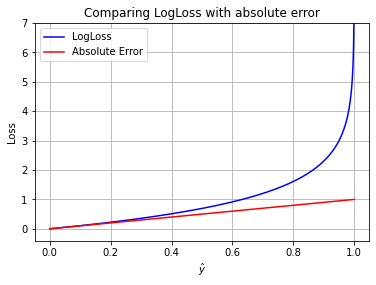

In [ ]:
def logloss(y, y_hat):
    y = np.clip(y, 1e-15, 1-1e-15)
    y_hat = np.clip(y_hat, 1e-15, 1-1e-15)
    return - np.mean(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

y = 0.0
predictions = np.linspace(0.0, 1.0, 1000)
loss = [logloss(y, y_hat) for y_hat in predictions]
mae  = [np.abs(y - y_hat) for y_hat in predictions]
plt.plot(y_hat, loss, c='b', label='LogLoss')
plt.plot(y_hat, mae, c='r', label='Absolute Error')
plt.ylim(-0.4, 7)
plt.grid()
plt.title('Comparing LogLoss with absolute error')
plt.xlabel(r'$\hat{y}$')
plt.ylabel('Loss')
plt.legend()
plt.show()

In practice, we can use almost any library to optimize the logloss metric:
- **Tree-based:** XGBoost, LightGBM
- **Linear models:** sklearn.<>Regression, sklearn.SGDRegressor, Vowpal Wabbit
- **Neural networks:** PyTorch, Keras, TensorFlow

### Cohen's Kappa

When we have highly imbalanced datasets (say, a binary target value distributed as $f_0=0.1$ and $f_1=0.9$), then, by always predicting the most frequent class we can obtain pretty high accuracy (in our example it would be equal to $0.9$). Anyway, as we know, a model of such kind would be useless. Consider now a metric defined as

$$loss = 1 - \frac{1 - \text{accuracy}}{1 - \text{baseline_acc}}$$

that, for an accuracy of $1$ it assigns a score of $1$, and for the baseline accuracy ($0.9$ in our example) it assigns a score of $0$. Baselines are going to be different for each dataset. In [Cohens's Kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) we take another value as the baseline: what the accuracy would be on average, if we randomly permute our predictions.

$$\text{Cohen's Kappa} = 1 - \frac{1 - \text{accuracy}}{1 - p_e}$$

where $p_e = \frac{1}{N^2}\sum_{k} n_{k1}n_{k2}$ and $n_{ki}$ is the number of times classifier $i$ predicted category $k$.

Now, we are going to introduce weighted Kappa. In order to do that, assume we are solving a $K=3$ classes classification problem, where the dataset contains:

| class | n_instances |
|:-----:|:-----------:|
|   1   |      10     |
|   2   |      90     |
|   3   |      20     |

We want to penalize more a certain mistake (e.g. we want to penalize predicting class 3 when the true class was class 1 or class 2). In order to accomplish that, we build an error weight matrix $W$, in which we weight that kind of error to be 10 times larger than any other type of error:

| pred \ true | 1 | 2 | 3  |
|:-----------:|:-:|---|----|
|    **1**    | 0 | 1 | 10 |
|    **2**    | 1 | 0 | 10 |
|    **3**    | 1 | 1 | 0  |

To compute the weighter error we also need the confusion matrix $C$. For instance, let it be:

| pred \ true | 1 | 2  | 3  |
|:-----------:|:-:|----|----|
|      1      | 4 | 2  | 3  |
|      2      | 2 | 88 | 5  |
|      3      | 4 | 10 | 12 |

Then, the weighted error can be computed by multiplying $W$ and $C$ element-wise and normalizing the result:

$$\text{weighted error} = \frac{1}{const}\sum_{ij}C_{ij}W_{ij}$$

Finally, the weighted kappa can be computed as:

$$\text{weighted kappa} = 1 - \frac{\text{weighted error}}{\text{weighted baseline error}}$$

Let's now take a moment to discuss how to compute the weight matrix. For a classification problem where the classes have an order, then we can use _linear weights_ and compute the distance between two labels as $w_{ij} = \vert i - j \vert$. In a similar fashion, we can use _quadratic weights_, cumputed as $w_{ij} = (i - j)^2$. Quadratic weighted kappa is usually explained as **inter-rater agreement coefficient**: how much the predictions of the model agree with ground-truth raters, which is quite intuitive for medicine applications,
where we want to know how much the model agrees with the opinion of professional doctors.

There are two main ways to optimize quadratic kappa metric in practice:
- Optimize MSE 

$$\text{kappa}(y, \hat{y}) \approx 1 - \frac{\frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y}_i)^2}{\text{hard to deal part}}$$

and find right thresholds (avoid rounding the predictions but instead optimize the thresholds with grid search). The _"hard to deal part"_ at the denominator depends on the predictions and it is explained in detail by [this paper](https://arxiv.org/abs/1509.07107).

- Custom smooth loss for GBDT or neural nets

<a name='Model-selection'></a>
# Model selection: detecting and fixing errors

The main two errors that occour in machine learning projects are ***underfitting and overfitting***. **Underfitting** is some sort of oversimplification of the problem, and a typical symptom of this phenomenon is that our model doesn't perform well on the training set. We call this type of error an error due to bias. On the other hand, **overfitting** is some sort of overcomplication of the model. When this happens, the model does well in the training set, but it tends to memorize it instead of learning its characteristics, performing bad on the test set. We call this type of error an error due to variance. Our goal is to obtain a model with a low rate of error both in the training set and in the test set.

We must remember to never use our testing data for training, since the model would obtain a perfect score in predicting the labels of data that it has already seen, but it would fail to predict anything useful on yet-unseen data (situation of overfitting). We can further split our dataset in this way: instead of just having a **training set** and a **test set**, we also build a **cross validation set**. The training set will be used to train the parameters, the cross validation set will be used for making decisions about the model (to tune its hyperparameters, such as the polynomial degree of a regression model), and the test set will be used for the final testing of the model (to evaluate its performance on yet unseen data).

## Cross validation

Cross validation is a statistical method used to estimate the skills of a model. A type of cross validation technique is the ***k-fold cross validation***. The idea behind this method is to split our dataset into $k$ buckets after having randomly shuffled it, in order to remove any hint of a bias, then, for each bucket, we consider it as the test set, and the remaining ones as training set. After that, we train our model using the training set (i.e. using $k-1$ of the folds), whose size is $\frac{k-1}{k}$ the size of the initial dataset, we evaluate it using the test set, whose size is $\frac{1}{k}$ the size of the initial dataset, retain the evaluation score and discard the model. The performance measure reported by *k*-fold cross-validation is then the average of the values computed in the loop.

In [ ]:
from sklearn.model_selection import KFold

X = range(12)
kf = KFold(n_splits=4, shuffle=True)
for train, test in kf.split(X):
    print(train, test)

[ 0  1  3  4  6  7  9 10 11] [2 5 8]
[ 0  2  5  6  7  8  9 10 11] [1 3 4]
[ 1  2  3  4  5  6  7  8 10] [ 0  9 11]
[ 0  1  2  3  4  5  8  9 11] [ 6  7 10]


If we have little data, k-fold cross validation may fail: consider 8 samples in a binary classification problem, uniformily distributed with respect to the target variable (4 samples with target equal to one, and 4 equal to zero). Assume that, after having randomly shuffled them, we perform 4 folds, we can end up having these folds:
- `[0,0,0,1,1,1][0,1]` the first time
- `[0,0,1,1,1,1][0,0]` the second time
- `[0,0,0,0,1,1][1,1]` the third time
- `[0,0,0,1,1,1][1,0]` the fourth time

when we use `[0,0]` or `[1,1]` as validation sets, we train a model using an imbalanced dataset, with 1/3 of the target values being of a certain value, and 2/3 being the opposite. This can drastically affect the predictions of our model. In order to handle this problem we use **stratification**: a way to ensure we **get similar target distributions** over different folds. 

Stratification is useful with:
- small datasets
- unbalanced datasets
- multiclass classification with a large amount of classes

Another technique we can use when data is little is **leave-one-out validation**, which is like k-fold cross validation, but it performs a number of folds which is equal to the number of training examples, every time using the i-*th* training example as the test set (which is then a singleton), and the remaining ones as the training set. The final prediction will be the average of the predictions from all the models, each trained on a different training set.

In [ ]:
from sklearn.model_selection import LeaveOneOut

X = range(12)
loo = LeaveOneOut()
for train, test in loo.split(X):
    print(train, test)

[ 1  2  3  4  5  6  7  8  9 10 11] [0]
[ 0  2  3  4  5  6  7  8  9 10 11] [1]
[ 0  1  3  4  5  6  7  8  9 10 11] [2]
[ 0  1  2  4  5  6  7  8  9 10 11] [3]
[ 0  1  2  3  5  6  7  8  9 10 11] [4]
[ 0  1  2  3  4  6  7  8  9 10 11] [5]
[ 0  1  2  3  4  5  7  8  9 10 11] [6]
[ 0  1  2  3  4  5  6  8  9 10 11] [7]
[ 0  1  2  3  4  5  6  7  9 10 11] [8]
[ 0  1  2  3  4  5  6  7  8 10 11] [9]
[ 0  1  2  3  4  5  6  7  8  9 11] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]


## Bootstrap method

The bootstrap method is a resampling technique used to estimate statistics on a population by averaging estimates from multiple small data samples constructed by **sampling** a dataset **with replacement**. Each training dataset is constructed by sampling with replacement a larger dataset. The samples not included in the sample we constructed, are called *Out-Of-Bag* samples (OOB).

The general procedure can be thought as follows:
1. Choose a number of bootstrap samples to perform
2. Choose a sample size
3. For each bootstrap sample: 
    - Draw a sample with replacement with the chosen size  
    - Fit a model on the data sample  
    - Estimate the skill of the model on the out-of-bag sample  
4. Calculate the mean of the sample of model skill estimates


## Considerations to make when splitting the dataset into train/validation

Sometimes, such as it usually happens in competitions (e.g. Kaggle), it may happen that we are already provided with training and test set, so we just have to split the training set further into training and validation sets. Suppose that we are facing the problem to predict the number of customers of a shop in the nearby future (so we are dealing with time series). What is an appropriate approach to divide the data into train and validation? 

We have two approaches:

1. Take random rows in validation
2. Make a time based split: take everything before a certain date as the training set, and everything after as the validation set.

If we choose the first approach, then in our training set there will be missing days scattered throughout the entire time period. In order to predict a response for those missing days, we could interpolate the days before and after the missing ones. Anyway, if our goal is to make predictions about the future, a model built on a dataset of this kind will be useless, since we have no data after the period we want to predict. Note that this kind of splitting is not necessarily useless, since the **general rule** is that the **train/validation split must mimic the train/test split**.

Suppose we have a pool of models trained on different features, and we select the best model for each of the two types of validation. Will the two models differ? The answer is yes, indeed, if we try to predict future outcomes, using a model that combines features from previous and next target values will perform poorly because we don't have such observations in the future test data. Consider instead the second approach. Here we rely on the time trend, so the features needed by the model are more like "what was the trend over the past week?". To conclude the comparison, we say that most useful features for one model can be useless for another.

Generated features are not the only issue. Assume that the actual train/test split follows the second approach (it is time-based). If we created features that are drawing attention to time-based patterns but are useless for a random split, would it be correct to use a random split to select the model?

In order to answer this question, consider a dataset where the observations follows a linear trend. The most simple model would predict the mean of the training data. Let's see what would happen with both the two approaches.

<img src="https://github.com/pietroventurini/machine-learning-notes/blob/main/images/model-evaluation/random_vs_time-based.png?raw=1" alt="Learning curves" style="display: block; margin-left: auto; margin-right: auto; width:50%">

With the random split, by predicting the sample mean we would obtain a better score on the validation set than on the test set. With the time-based split, instead, the validation points are as far as the test points from the target mean value, yelding a validation score which is more similar to the test score.

Splits can be grouped into different main categories:

1. **Random, rowise:** this usually means that rows are independent of each other. If we were predicting if a client would pay a loan, then there can be some sort of dependence, for instance, between family members or between co-workers: if a husband can pay a debit, probabily is wife can pay it too. So, if it happens that the husband is in the training data, and the wife is in the test data, we probably can exploit this by devising a special feature for that case.
2. **Time-based:** in this case, we generally have everything before a certain date as training data, and everything after that date as test data. In a problem like the one of predicting the number of clients of a shop, then useful features can be _"the number of clients for that shop, the same day of the previous week"_, or _"the average number of clients during last month"_. An effective train/validation split for cases like this is the **moving window validation**: we progressively move the date that divides the training from the validation, and training a model each time:

| Week 1 | Week 2 |   Week 3   |   Week 4   |   Week 5   |   Week 6   |
|:------:|:------:|:----------:|:----------:|:----------:|:----------:|
|  Train |  Train | Validation |      -     |      -     |      -     |
|  Train |  Train |    Train   | Validation |      -     |      -     |
|  Train |  Train |    Train   |    Train   | Validation |      -     |
|  Train |  Train |    Train   |    Train   |    Train   | Validation |

3. **ID-based:** the ID can be a unique identifier for users, shops or any other entity. For instance, consider the task of making music reccomendations for different users, where the training set and the test set contains completely different users. Therefore, features such as the total listening time in the last 72 hours can be little informative when making predictions about new users. The train/validation split must mimic the train/test one, so, we must ensure that users in the training set are different from users in the validation set. If the IDs are not given, we should derive them ourselves, for instance, by applying clustering and grouping under the same ID different rows that resulted to belong to the same cluster.
4. **Combined:** again, consider the clients/shops problem. Instead of performing a time-based split according to a single date, we can use different dates for different shops. If we consider the music reccomendation example, then we can choose to put only the last song a user listened to in the validation set.


## Learning curves

A learning curve is a plot of model learning performance over experience or time. The model can be evaluated on the training dataset and on a *hold out validation dataset* after each update during training, and plots of the measured performance can be created to show learning curves. Learning curves of model performance on the train and validation dataset can be used to diagnose an underfit, overfit, or well-fit model.

Let's consider 3 different models, respectively, one that underfits the data, one that is ok, and one that overfits the data. We can plot, for each of the three models, the training error and the cross validation error as the number of training points varies.

<img src="https://github.com/pietroventurini/machine-learning-notes/blob/main/images/model-evaluation/learning-curves.png?raw=1" alt="Learning curves" style="display: block; margin-left: auto; margin-right: auto; width: 650px" />

The training learning curve gives an idea of how well the model is learning. The validation learning curve gives an idea of how well the model is generalizing.

**High validation errors** indicate a **bias problem**, but they don't give the directionality of the bias, which can instead be guessed from the training error:
- A **high training error** indicates **high bias** (underfitting model, the model is too simple).
- A **low training error** indicates **low bias** (overfitting model, the model is to complex, it performs well on the training examples but it fails to generalize).

The **variance** of the model can be estimated in at least two ways:
- By looking at the **gap** between the validation learning curve and the training learning curve. Generally, **the more narrow the gap, the lower the variance** and the wider the gap, the greater the variance. High variance means that the model fits the data too well and will have problems generalizing on new unseen data.
- By examining the training error evolution as the training set size increases.

Note that if we talk about score, instead of error, then the reasoning change: the higher the error, the lower the score. Thus, when you see the curve of scores, you need to flip it upside down in your mind, in order to compare it with the curves above.

In [ ]:
from sklearn.model_selection import learning_curve

# It is a good practice to randomize data before drawing Learning Curves
def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation,:]
    Y2 = Y[permutation]
    return X2, Y2

# Procedure to draw the learning curves of a certain model
def draw_learning_curves(X, y, estimator, num_trainings, estimator_name):
    X2, y2 = randomize(X, y)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X2, y2, 
                                                            cv=3, 
                                                            n_jobs=1, 
                                                            train_sizes=np.linspace(.1, 1.0, num_trainings))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid(True, alpha=0.3)
    plt.title("Learning Curves: {}".format(estimator_name))
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="y",
             label="Cross-validation score")

    plt.legend(loc="best")

    plt.show()

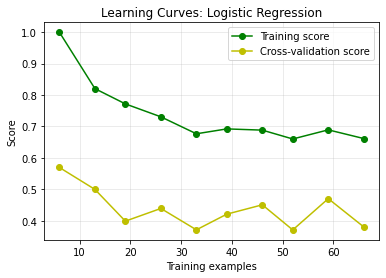

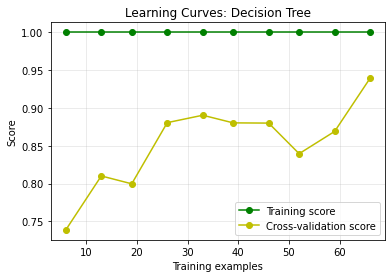

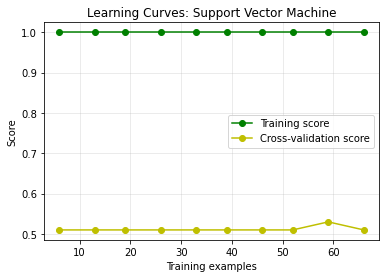

In [ ]:
import pandas as pd
import numpy as np

# Import, read, and split data
data = pd.read_csv('datasets/model_evaluation/data_learning_curve.csv')
X = np.array(data[['x1', 'x2']])
y = np.array(data['y'])

# Fix random seed
np.random.seed(55)

### Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

### Logistic Regression
estimator_LR = LogisticRegression(solver='liblinear')

### Decision Tree
estimator_GBC = GradientBoostingClassifier()

### Support Vector Machine
estimator_SVC = SVC(kernel='rbf', gamma=1000)

draw_learning_curves(X, y, estimator_LR, 10, 'Logistic Regression')
draw_learning_curves(X, y, estimator_GBC, 10, 'Decision Tree')
draw_learning_curves(X, y, estimator_SVC, 10, 'Support Vector Machine')

The last example shows how three different classifiers perform differently on the same dataset:
1. **Logistic Regression:** Underfits (low training and testing score, so we will not benefit much from more training data).
2. **Decision Tree:** It's ok (high training and testing score).
3. **Support Vector Machine:** Overfits (high training score, low testing score).


Indeed, we can check it by visualizing the estimators:

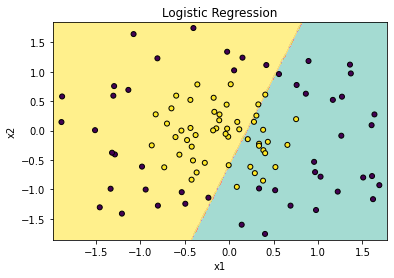

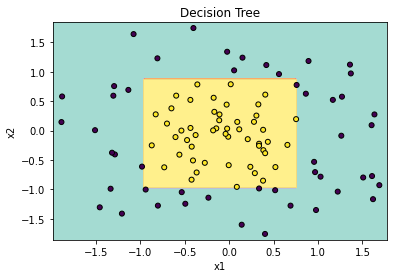

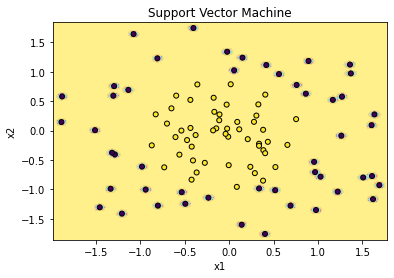

In [ ]:
def plot_estimator(X, y, estimator, estimator_name):
    # Fit the classifier to the data
    estimator.fit(X,y)

    # Plot data and decision boundaries
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),
                         np.arange(y_min, y_max, .01))

    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()]) # predict Z for every point of the meshgrid
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Set3, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], marker='o', c=y, s=25, edgecolor='k')
    plt.title(estimator_name)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()
    
plot_estimator(X, y, estimator_LR, 'Logistic Regression')
plot_estimator(X, y, estimator_GBC, 'Decision Tree')
plot_estimator(X, y, estimator_SVC, 'Support Vector Machine')

## Grid search
Grid-search is a method to understand which combination of hyperparameter values is optimal (in the sense that maximizes a performance score) for training a model, by performing an exhaustive search through a manually specified subset of the hyperparameter space of a learning algorithm. In other words, grid-search is used to find the optimal hyperparameters of a model which results in the most _accurate_ predictions.

For instance, when training a SVM classifier we typically have some hyperparameters to set, like the **kernel** which can be *linear* or *polynomial*. Another hyperparameter is the **gamma** parameter. Combining a subset of values for each of these two parameters, we'll obtain a grid which contains, in each of its cells, the F1 score (for instance). The combination of hyperparameters that leads to the highest F1 score, is the one we will select for our model.

<img src="https://github.com/pietroventurini/machine-learning-notes/blob/main/images/model-evaluation/grid-search.png?raw=1" alt="Search grid" style="display: block; margin-left: auto; margin-right: auto; width: 30em" />

Let's now try to use grid search to tune a support vector classifier (SVC).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

scorer = make_scorer(f1_score)
parameters = {'kernel':['poly', 'rbf'],'C':[0.1, 1, 10]}
# Create the object
grid_obj = GridSearchCV(estimator=SVC(), param_grid=parameters, scoring=scorer)
# Fit the data
grid_fit = grid_obj.fit(X, y)
# Get the best parameters
print(grid_fit.best_params_)

{'C': 10, 'kernel': 'rbf'}


## Different scores between validation and test set

If we obtain very different scores on the validation set and on the test set, we need to investigate the causes. For instance, consider a problem involving time-based data, where we decided to make a time-based split, and tuned a model according to a validation set made up of data from December. When using that model on test data from January, we discovered that the score has dropped dramatically. The cause may be the fact that the December has many more holidays than January, therefore our model, which was trained and tuned on data that did not reflect test data, performed poorly on future data. So, again, try to make a train/validation split that reflects the train/test split.

<a name='Mitchell'></a>
# Formalization of some concepts from _"Machine Learning"_ by Thomas Mitchell

```The following notes refers to the book: 'Machine Learning' by Thomas Mitchell (PP. 128-152)```

Consider the following setting for a learning problem, in which we want to learn a target function

$$f:X\rightarrow Y$$

where:
- $X$ is the space of possible instances
- $Y$ is the space of target values
- $D$ is an unknown probability distribution of the instances $x\in X$. Note that $D$ says nothing about the target value of an instance $x$.

The learning task is to learn the target function $f$ by considering a space $H$ of possible hypotheses. Training examples are provided to the learner by drawing each instance $x$ (together with its correct target value $f(x)$) independently, according to the distribution $D$.

Let's try to answer these questions:
1. Given an hypothesis $h$ and a data sample containing $n$ examples drawn at random according to $D$, what is the best estimate of $h$'s accuracy over future instances drawn from the same distribution?
2. What is the probable error in this accuracy estimate?

**Definition:** The **sample error** of a hypothesis with respect to a sample $S$ of $n$ instances drawn randomly from $X$ is the fraction of $S$ that it misclassifies.

$$error_S(h) \equiv \frac{1}{n}\sum_{x\in S}{\delta\left(f(x),h(x)\right)}$$

where $\delta(f(x),h(s)) = 1$ if $h(x)\neq f(x)$, $0$ otherwise.

**Definition:** The **true error** of a hypothesis is the probability that it will misclassify a single instance drawn from the distribution $D$.

$$error_D(h) \equiv Pr_{x\in D}[f(x)\neq h(x)]$$

## Confidence intervals for discrete-valued hypothesis

We want to answer the question "*How good an estimate of $error_D(h)$ is provided by $error_S(h)$?*" for a **discrete-valued hypothesis**.

**[Confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval)** are interval estimators that propose a range of plausible values for an unknown parameter ($error_D(h)$). An interval has an associated probability (confidence level) that the true parameter lies within the interval. So, a $N\%$ confidence interval estimate for parameter $p$ is an interval that includes $p$ with probability $N\%$.

Recall that $error_S(h) = r/n$, where $n$ is the number of samples in $S$ drawn randomly according to $D$ and $r$ is the number of errors committed by $h$ over the $n$ samples.

1. Given no information, the most probable value of $error_D(h)$ is $error_S(h)$.
2. With approximately 95% probability, the true error $error_D(h)$ lies in the interval

$$error_S(h) \pm 1.96\sqrt{\frac{error_S(h)(1 - error_S(h))}{n}}$$

This means that, if we repeat the experiment of drawing each time a new sample $S_i$ containing $n$ new samples, then, for approximately 95% of these experiments, the calculated interval would contain the true error $error_D(h)$. That interval is called the 95% confidence interval estimate for $error_D(h)$.

More generally, the $N\%$ confidence interval estimate for $error_D(h)$ is

$$error_S(h) \pm z_N\sqrt{\frac{error_S(h)(1 - error_S(h))}{n}}$$

where $z_N$ depends on the desired confidence level (this formula will be derived in the [following sections](#More-on-confidence-intervals)).

This is true under these assumptions:
- $h$ is a discrete-valued hypothesis (model).
- $S$ is drawn at random using the same distribution from which future data will be drawn.
- $S$ is independent from the training data used for generating $h$ (the data is independent from the hypothesis being tested).

In general, this approximation is good when $n\ge30$ and $error_S(h)$ is not too close to 0 or 1. A general rule of thumb is that $n\cdot error_S(h)(1 - error_S(h)) \ge 5$.

## Error estimation
We ask ourserlves "***how does the deviation between the sample error and the true error depends on the size of the sample?***". More generally, this question is an instance of the problem of estimating the proportion of a **population** that exhibits some properties (e.g. the property that $h$ will misclassify an example), given the observed proportion over some random **sample of the population**. <br>
Assume that we repeat the experiment of drawing each time a new sample $S_i$ of size $n$. Then, $error_{S_i}(h)$, the outcome of the *i*-th experiment, is a **random variable** whose values are the observed outcomes of the many experiments. If we repeat the experiment a large number of times, our random variable will behave like a **[Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)**.

<img src="https://github.com/pietroventurini/machine-learning-notes/blob/main/images/model-evaluation/binomial.jpg?raw=1" alt="Binomial distribution" style="display: block; margin-left: auto; margin-right: auto; width:30em" />


$$P(r)= \binom{n}{r}p^r(1-p)^{n-r}  = \frac{n!}{r!(n-r)!}p^r(1-p)^{n-r}$$

If $X$ is a random variable that follows a Binomial distribution, then $Pr(X=r)=P(r)$. Its mean, variance and standard deviation are, respectively:

$$E[X]=np, \qquad Var(X)=np(1-p) \qquad \sigma_X = \sqrt{Var(X)}$$

Consider the example of a coin being toss: the binomial distribution gives the probability of observing $r$ heads in an example of $n$ independent coin tosses, when the probability of heads on a single coin toss is $p$.

Now, suppose that we don't know $p$: we can toss the coin $n$ times, record the number of times $r$ that we obtained head. A reasonable estimate for $p$ is $p=r/n$. If the experiment were rerun, $r$ might be different, yelding a different estimate of $p$.

The Binomial distribution describes for each possible value of $r$ (i.e. from 0 to $n$), the probability of observing exactly $r$ heads given a sample of $n$ independent tosses of a coin, whose true probability of heads is $p$. Estimating $p$ from a random sample of coin tosses is equivalent to estimating $error_D(h)$ from testing $h$ on a random sample of instances.

A single toss of the coin is equivalent to drawing a single instance form $D$ and determining whether it is misclassified by $h$, and so $p$ corresponds to the probability that a single instance randomly drawn will be misclassified ($p=error_D(h)$).

The number $r$ of heads observed over a sample of $n$ coin tosses corresponds to the number of misclassifications observed over $n$ randomly drawn instances. Thus $r/n$ corresponds to $error_S(h)$.

The Binomial distribution depends on the specific sample size $n$ and the specific probability $p$ or $error_D(h)$.

Now, let's return to the question: ***What is the likely difference between $error_S(h)$ and the true error $error_D(h)$?*** Let's call:

$$error_S(h)=\frac{r}{n} \qquad error_D(h)=p$$

$error_S(h)$ is an **estimator** for $error_D(h)$. The **estimation bias** of an estimator $Y$ of a parameter is the difference between the expected value of the estimator and the parameter's true value $p$.

$$\text{Estimation bias } = E[Y] - p$$

If the estimation bias is zero, then $Y$ is an **unbiased estimator** of $p$. In our case $error_S(h)$ is an unbiased estimator of $error_D(h)$, indeed, $E[error_S(h)]=E[r/n]=p$ (because $n$ is constant and $r$ follows a Binomial distribution).

**Take home messages:** 
- In order for $error_S(h)$ to give an unbiased estimate of $error_D(h)$, the **hypothesis $h$ and sample $S$ must be chosen independently**. For this reason, if we train a model over a **training set**, we won't evaluate its performance on the same set used to train it, but we will do it on a different **test set**, drawn from the same underlying distribution (this means that if we only have a limited sample, and we are not allowed to request new data from the underlying true distribution, then we have to split the data we have into different sets, and use each one for a different task).

- Possible causes of prediction bias are:
    - Noisy data
    - Incomplete feature set
    - Biased training examples
    - Overly strong regularization

**Note:** Adding a **calibration layer** (post process the predictive model) to reduce the prediction bias of the model is **NOT a good idea** because it's like fixing the symptoms rather than the cause (and mantaining calibration layer in a project can be tedious).

Given a choice among alternative unbiased estimators, choose the one with least **variance** (this choice will lead to the smallest expected squared error between the estimate and the true value of the parameter). We have said that an unbiased estimate for $error_D(h)$ is given by $error_S(h)=r/n$. The variance of this estimate arises from the variance in $r$ (because $n$ is constant) which is Binomially distributed. Its variance is $Var(r)=np(1-p)$ but $p$ is unknown. So, we substitute to $p$ our unbiased estimate $error_S(h)=r/n$, yelding the following approximation for the standard deviation of $error_S(h)$:

$$\sigma_{error_S(h)} = \frac{\sigma_r}{n} = \sqrt{\frac{p(1-p)}{n}} \approx \sqrt{\frac{error_S(h)(1-error_S(h))}{n}}$$

### More on confidence intervals

The confidence intervals for the parameter $error_D(h)$ can be derived from the fact that its estimator $error_S(h)$ follows a Binomial distribution, with:

$$E[error_S(h)] = error_D(h) \qquad \sigma_{error_S(h)} \approx \sqrt{\frac{error_S(h)(1-error_S(h))}{n}}$$

To derive a $N\%$ confidence interval, we have to find the interval centered around the mean value $error_D(h)$, which contains $N\%$ of the total probability under this distribution. In other words, $N\%$ of the time, the estimate $error_S(h)$ will fall within that interval sorrounding $error_D(h)$. For large $n$, any Binomial distribution is very
closely approximated by a Normal distribution with the same mean and variance.

If a random variable $Y\sim \mathcal{N}(\mu,\sigma^2)$, then the measured random value $y$ of $Y$ will fall into the interval $[\mu \pm z_N\sigma]$, $N\%$ of the time. Equivalently, the mean $\mu$ will fall $N\%$ of the time into the interval:

$$y\pm z_N\sigma$$ 

where $z_N$ gives half the width of the interval (i.e., the distance from the mean in either direction) measured
in standard deviations that includes $N\%$ of the total probability mass under the bell-shaped Normal distribution.

Now, if we substitute the mean and standard deviation of $error_S(h)$ into this last formula, we will find:

$$error_S(h) \pm z_N\sqrt{\frac{error_S(h)(1 - error_S(h))}{n}}$$

In deriving this expression two approximations have been made:
1. When estimating the standard deviation $\sigma$ of $error_S(h)$, we have approximated $error_D(h)$ by $error_S(h)$.
2. The Binomial distribution has been approximated by a Normal distribution.

#### One sided intervals
If we were interested only in a *one-sided* bound (e.g. *What is the probability that $error_D(h)$ is at most U?*), thanks to the fact that the Normal distribution is symmetrical about its mean, any two-sided confidence interval based on a Normal distribution can be converted to a corresponding **one-sided interval with twice the confidence**. A $100(1- a)\%$ confidence interval with lower bound $L$ and upper bound $U$ implies a $100(1- a/2)\%$ confidence interval with lower bound $L$ and no upper bound.

## Comparing two hypotheses
Consider two hypotheses, $h_1$ and $h_2$, that have been respectively tested on samples $S_1$ (of dimension $n_1$) and $S_2$ (of dimension $n_2$), both drawn from the same distribution. We wish to estimate the difference between the true errors of these two models:

$$d\equiv error_D(h_1) - error_D(h_2)$$

An estimator for $d$ is the difference $\hat{d}$ between the sample errors:

$$\hat{d} \equiv error_{S_1}(h_1) - error_{S_2}(h_2)$$

It can be shown that $\hat{d}$ gives an unbiased estimate of $d$ that is $E[\hat{d}]=d$.

For sufficiently large $n_1$ and $n_2$, both $error_{S_1}(h_1)$ and $error_{S_2}(h_2)$ will follow approximately a Normal distribution, and so will $\hat{d}$. That distribution will have mean $d$ and variance $\sigma_{\hat{d}}^2$.

$$\sigma_{\hat{d}}^2 \approx \frac{error_{S_1}(h_1)(1-error_{S_1}(h_1))}{n_1} + \frac{error_{S_2}(h_2)(1-error_{S_2}(h_2))}{n_2} $$

For random variable $\hat{d} \sim \mathcal{N}(d,\sigma^2)$, the $N\%$ confidence interval estimate for $d$ is $\hat{d}\pm z_N\sigma$. If we use the approximate variance $\sigma_{\hat{d}}^2$, then the approximate $N\%$ confidence interval estimate for $d$ is:

$$\hat{d}\pm z_N \sqrt{\frac{error_{S_1}(h_1)(1-error_{S_1}(h_1))}{n_1} + \frac{error_{S_2}(h_2)(1-error_{S_2}(h_2))}{n_2}}$$

This is acceptable also if $h_1$ and $h_2$ are tested on the same sample $S$, in that case the estimator $\hat{d}$ will have smaller variance and the confidence intervals will be tighter.

### Hypothesis testing
Suppose that the sample errors on two different samples of dimension $n_1=n_2=100$ are $error_{S_1}(h_1)=0.3$ and $error_{S_2}(h_2)=0.2$, the observed difference is $\hat{d}=0.1$.

*What is the probability that $error_D(h_1) > error_D(h_2)$ given $\hat{d}=0.1$?* This is equivalent to *"What is the probability that $d>0$ given $\hat{d}=0.1$?"*. Note that $Pr(d>0)$ is equal to the probability that $\hat{d}$ hasn't overestimated $d$ by more than 0.1. This is the probability that $\hat{d}$ falls into the left-opened interval $(-\infty, d+0.1]$. Since $\mu_{\hat{d}}=E[\hat{d}]=d$, that interval can be expressed as $(-\infty, \mu_{\hat{d}}+0.1]$. We can compute $\sigma_{\hat{d}}\approx 0.061$ and express the interval in terms of standard deviations it allows deviating from the mean

$$(-\infty, \mu_{\hat{d}}+1.64\sigma_{\hat{d}}]$$

For a normal distribution, 1.64 standard deviations about the mean corresponds to a two-sided interval with confidence level 90%, therefore for a one-sided interval, the corresponding confidence level will be 95%. In other words, given the observed $\hat{d}=0.1$, then $error_D(h_1)>error_D(h_2)$ with a probability of 95%.

## Comparing learning algorithms

Instead of comparing different models, we may want to compare different learning algorithms, for instance $L_A$ and $L_B$, in order to learn some target function $f$. To determine which algorithm is better *on average*, we can average their relative errors over all training sets of size $n$ that can be drawn from the underlying distribution $D$.

$$E_{S\subset D} \left[error_D(L_A(S)) - error_D(L_B(S))\right]$$

$L(S)$ is the hypothesis that the learning method produces using the training set $S$. $S\subset D$ indicates that the expected value is taken over samples $S$ randomly drawn from the underlying distribution $D$. Anyway, we only have a limited subset $D_0$ of data. For this reason we split $D_0$ into a training set $S_0$ and a test set $T_0$ that will be used respectively to train the learning algorithm and to test the accuracy of the learned model. Thus, we measure:

$$error_{T_0}(L_A(S_0)) - error_{T_0}(L_B(S_0))$$

we're using $error_{T_0}(h)$ to approximate $error_D(h)$ and a single training set $S_0$ rather than all samples $S$ that can be drawn from $D$. To improve the performance of this estimator, we can perform ***k-fold cross validation*** by partitioning $D_0$ into $k$ disjoint sets, and training and testing each algorithm $k$ times, each time using one of the $k$ buckets as the test set $T_i$ and the remaining as the training set $S_i = D_0 - T_i$. The dimension of the training set will be $\frac{k-1}{k}|D_0|$ and the dimension of the test set will be $\frac{1}{k}|D_0|$.

The average difference in errors 

$$\bar{\delta}=\frac{1}{k}\sum_{i=1}^k{}\delta_i$$

where $\delta_i=error_{T_i}(h_A) - error_{T_i}(h_B)$ and $h_A$ is produced by $L_A(S_i)$, is an estimate of the difference between the two learning algorithms. In other words, $\bar{\delta}$ estimates the quantity:

$$E_{S\subset D_0}\left[error_D(L_A(S)) - error_D(L_B(S))\right]$$

where $S$ represent a set of dimension $\frac{k-1}{k}|D_0|$ randomly drawn from $D_0$. In this expression we take the expected value over subsets $S$ of the *available* data $D_0$. If $\bar{\delta}<0$, we can estimate that $L_A$ is better than $L_B$.